<a href="https://colab.research.google.com/github/64060kbarot/AML_64061/blob/main/Assignment2_Convolution_Cat_Dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Assignment 2: Convolutional***

In this assignment, you will examine the relationship between training samples and the choice
of training your model from scratch, versus using a pretrained convnet. Specifically, answer the
following questions:
1. Consider the Cats & Dogs example. Start initially with a training sample of 1000, a
validation sample of 500, and a test sample of 500 (like in the text). Use any technique
to reduce overfitting and improve performance in developing a network that you train
from scratch. What performance did you achieve?
2. Increase your training sample size. You may pick any amount. Keep the validation and
test samples the same as above. Optimize your network (again training from scratch).
What performance did you achieve?
3. Now change your training sample so that you achieve better performance than those
from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous
steps. The objective is to find the ideal training sample size to get best prediction
results.
4. Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in
Steps 2 and 3 for the pretrained network may be the same or different from those using
the network where you trained from scratch. Again, use any and all optimization
techniques to get best performance.


In [1]:
#Loading all the required libraries and functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import zipfile
import io
import os
import shutil
import pathlib
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from io import BytesIO
from zipfile import ZipFile

In [2]:
#Importing the JSON Activation Code
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"kandarpbarot1","key":"c1bf2d39039029bd384fc0e6e6a98267"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
#Downloading the Data
!kaggle competitions download -c dogs-vs-cats

dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip -o -qq dogs-vs-cats.zip

In [7]:
!unzip -o -qq train.zip

In [6]:
!pip install tensorflow==2.12

# ***1.Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?***

In [8]:
import os, shutil, pathlib
#shutil.rmtree("cats_vs_dogs_small/train/cat")

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok = True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=500)
make_subset("validation", start_index=1000, end_index=1250)
make_subset("test", start_index=1500, end_index=1750)

In [9]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 1000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [10]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


*Model_MaxPooling_filter32_512_Layer5*

In [11]:
#Building the model
#Instantiating a small convnet for dogs vs. cats classification
#*Model - 1 MaxPooling Operation with Increase in filters from 32 to 256 in 5 Input Layers*

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)


model = keras.Model(inputs=inputs, outputs=outputs)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

<font size="3"> Training the model 1 </font>

In [13]:
# Compilimg the results of the model
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])


# Saving the results of the model
callbacks = ModelCheckpoint(
            filepath= "model1.keras",
            save_best_only= True,
            monitor= "val_loss"
            )


# Fitting/Running the Model
Model_1 = model.fit(
          train_dataset,
          epochs= 10,
          validation_data= validation_dataset,
          callbacks= callbacks)

Epoch 1/20
32/32 [==============================] - 29s 860ms/step - loss: 0.6975 - accuracy: 0.5130 - val_loss: 0.6917 - val_accuracy: 0.5000
Epoch 2/20
32/32 [==============================] - 27s 857ms/step - loss: 0.6935 - accuracy: 0.4880 - val_loss: 0.6922 - val_accuracy: 0.5000
Epoch 3/20
32/32 [==============================] - 27s 835ms/step - loss: 0.6937 - accuracy: 0.5450 - val_loss: 0.6869 - val_accuracy: 0.5760
Epoch 4/20
32/32 [==============================] - 28s 863ms/step - loss: 0.6894 - accuracy: 0.5510 - val_loss: 0.6815 - val_accuracy: 0.5260
Epoch 5/20
32/32 [==============================] - 27s 842ms/step - loss: 0.6772 - accuracy: 0.5580 - val_loss: 0.6668 - val_accuracy: 0.6000
Epoch 6/20
32/32 [==============================] - 29s 902ms/step - loss: 0.6379 - accuracy: 0.6440 - val_loss: 0.6357 - val_accuracy: 0.6320
Epoch 7/20
32/32 [==============================] - 29s 912ms/step - loss: 0.6324 - accuracy: 0.6510 - val_loss: 0.6417 - val_accuracy: 0.6520

<font size="3"> Looking at the visuals of the Training and Validation Accuracy/Loss</font>

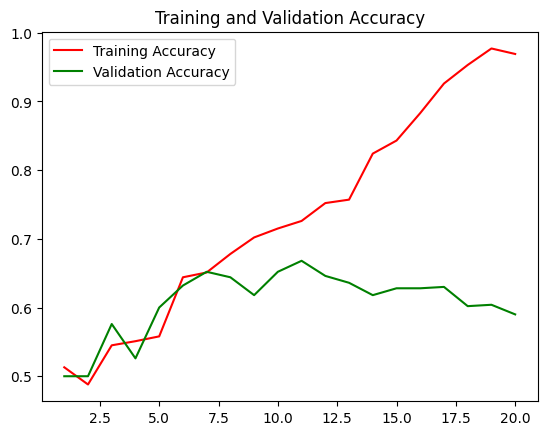

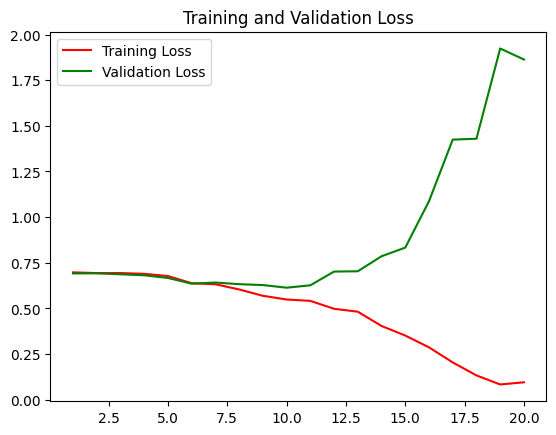

In [17]:
accuracy = Model_1.history["accuracy"]
val_accuracy = Model_1.history["val_accuracy"]

loss = Model_1.history["loss"]
val_loss = Model_1.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color= "Red", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="Green", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="Red", label="Training Loss")
plt.plot(epochs, val_loss, color="Green", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [19]:
#Evaluating the performance of Model_1
test_model = keras.models.load_model("model1.keras")
Model1_Results = test_model.evaluate(test_dataset)
print(f'Loss: {Model1_Results[0]:.3f}')
print(f'Accuracy: {Model1_Results[1]:.3f}')

16/16 [==============================] - 3s 186ms/step - loss: 0.6369 - accuracy: 0.6620
Loss: 0.637
Accuracy: 0.662


*Using Measures to Avoid Overfitting*
*Data Augmentation*

In [20]:
# To deprecate warnings that are making the output look clumsy
import logging
logging.getLogger('tensorflow').disabled = True

In [21]:
#Using few of the techniques such as random flip, random zoom, random rotation so as to create augmented versions of the image
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

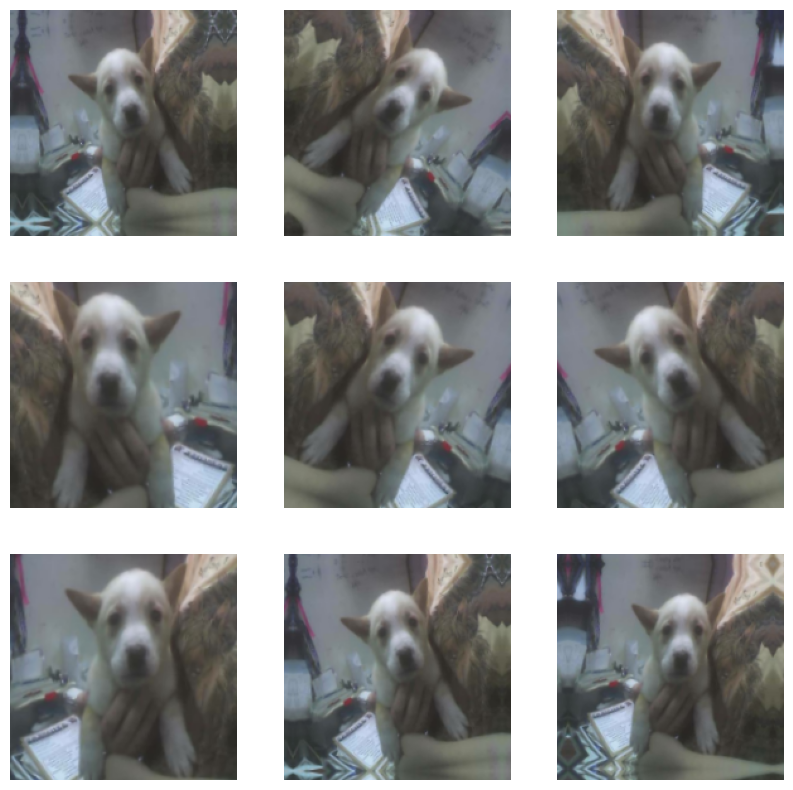

In [22]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
   for i in range(9):
      augmented_images = data_augmentation(images)
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_images[0].numpy().astype("uint8"))
      plt.axis("off")

*Model_Maxpooling_filters32_512_layer5_Augumentedimage_droput0.5*

In [27]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [28]:
# Compiling the model
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Saving the results of the model
callbacks = ModelCheckpoint(
            filepath= "model2.keras",
            save_best_only= True,
            monitor= "val_loss")

# Fitting/Running the Model
Model_2 = model.fit(
          train_dataset,
          epochs= 30,
          validation_data= validation_dataset,
          callbacks= callbacks)

Epoch 1/30
32/32 [==============================] - 31s 895ms/step - loss: 0.6975 - accuracy: 0.5230 - val_loss: 0.6890 - val_accuracy: 0.5000
Epoch 2/30
32/32 [==============================] - 29s 911ms/step - loss: 0.6862 - accuracy: 0.5510 - val_loss: 0.6687 - val_accuracy: 0.6100
Epoch 3/30
32/32 [==============================] - 29s 914ms/step - loss: 0.6761 - accuracy: 0.5810 - val_loss: 0.6517 - val_accuracy: 0.6380
Epoch 4/30
32/32 [==============================] - 29s 907ms/step - loss: 0.6622 - accuracy: 0.5930 - val_loss: 0.6667 - val_accuracy: 0.5900
Epoch 5/30
32/32 [==============================] - 29s 897ms/step - loss: 0.6546 - accuracy: 0.5980 - val_loss: 0.6782 - val_accuracy: 0.5740
Epoch 6/30
32/32 [==============================] - 29s 895ms/step - loss: 0.6246 - accuracy: 0.6460 - val_loss: 0.5983 - val_accuracy: 0.6740
Epoch 7/30
32/32 [==============================] - 29s 900ms/step - loss: 0.6062 - accuracy: 0.6660 - val_loss: 0.6014 - val_accuracy: 0.6900

In [1]:
accuracy = Model_2.history["accuracy"]
val_accuracy = Model_2.history["val_accuracy"]

loss = Model_2.history["loss"]
val_loss = Model_2.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="Red", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="Green", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="Red", label="Training Loss")
plt.plot(epochs, val_loss, color="Green", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

NameError: name 'Model_2' is not defined

<font size="3">Evaluating the performance of Model_2 on the test set</font>

In [26]:
test_model = keras.models.load_model("model2.keras")
Model2_Results = test_model.evaluate(test_dataset)
print(f'Loss: {Model2_Results[0]:.3f}')
print(f'Accuracy: {Model2_Results[1]:.3f}')

16/16 [==============================] - 4s 212ms/step - loss: 0.6386 - accuracy: 0.6620
Loss: 0.639
Accuracy: 0.662


*Model_MaxPooling_filter32_1024_Layers6_with_Augmentedimage_Dropout0.6*

In [ ]:
inputs = keras.Input(shape=(180,180,3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=1024, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.6)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 89, 89, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 87, 87, 128)       73856     
                                                           

In [ ]:
# Compiling the Model
model.compile(loss= "binary_crossentropy",
              optimizer= "adam",
              metrics= ['accuracy'])


# Monitoring the best validation loss using Callbacks
callbacks = ModelCheckpoint(
            filepath = "model4.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Model_4 = model.fit(
          train_dataset,
          epochs= 30,
          validation_data= validation_dataset,
          callbacks= callbacks
          )

Epoch 1/30
32/32 [==============================] - 6s 66ms/step - loss: 0.7233 - accuracy: 0.5100 - val_loss: 0.6917 - val_accuracy: 0.5380
Epoch 2/30
32/32 [==============================] - 1s 44ms/step - loss: 0.6933 - accuracy: 0.4990 - val_loss: 0.6862 - val_accuracy: 0.5420
Epoch 3/30
32/32 [==============================] - 1s 39ms/step - loss: 0.6897 - accuracy: 0.5320 - val_loss: 0.6877 - val_accuracy: 0.5800
Epoch 4/30
32/32 [==============================] - 1s 44ms/step - loss: 0.6934 - accuracy: 0.5300 - val_loss: 0.6826 - val_accuracy: 0.5680
Epoch 5/30
32/32 [==============================] - 1s 39ms/step - loss: 0.6887 - accuracy: 0.5280 - val_loss: 0.6877 - val_accuracy: 0.4960
Epoch 6/30
32/32 [==============================] - 1s 39ms/step - loss: 0.6816 - accuracy: 0.5380 - val_loss: 0.7028 - val_accuracy: 0.5100
Epoch 7/30
32/32 [==============================] - 1s 39ms/step - loss: 0.6902 - accuracy: 0.5290 - val_loss: 0.6838 - val_accuracy: 0.5280
Epoch 8/30
32

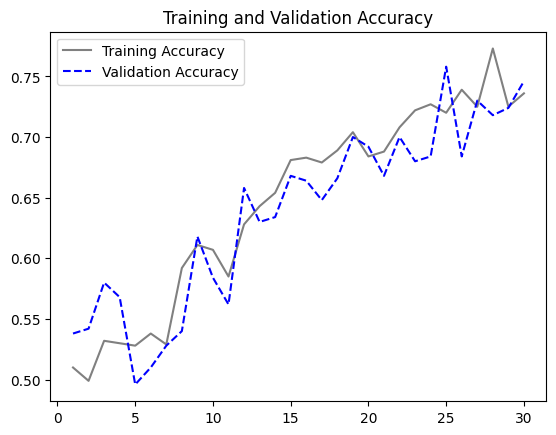

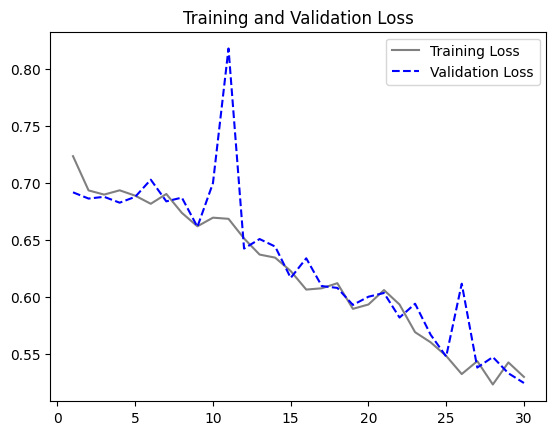

In [ ]:
accuracy = Model_4.history["accuracy"]
val_accuracy = Model_4.history["val_accuracy"]

loss = Model_4.history["loss"]
val_loss = Model_4.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="Red", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="Green", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="Red", label="Training Loss")
plt.plot(epochs, val_loss, color="Green", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

<font size="3">Evaluating the performance of Model_2 on the test set</font>

In [ ]:
best_model = keras.models.load_model("model4.keras")
Model4_Results = best_model.evaluate(test_dataset)
print(f'Loss: {Model4_Results[0]:.3f}')
print(f'Accuracy: {Model4_Results[1]:.3f}')

16/16 [==============================] - 1s 14ms/step - loss: 0.6037 - accuracy: 0.6800
Loss: 0.604
Accuracy: 0.680


<font size="3"><b>Summary for Question 1</b>: We did try to build 4 models with the training sample being 1000. Now lets compare the loss and Accuracy of all the 4 models to see which model gives better result</font>

<font size="3"><b>Model 1:</b> filters from 32 to 256, 5 Input Layers</font>

<font size="3"><b>Model 2:</b> filters from 32 to 256, 5 Input Layers, Augmented Images and Droput rate of 0.5</font>

<font size="3"><b>Model 3:</b> filters from 32 to 512, 6 Input Layers, Augmented Images and Dropout rate of 0.5</font>

<font size="3"><b>Model 4:</b> filters from 64 to 1024, 5 Input Layers, Augmented Images and Dropout rate of 0.6 </font>

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display

Models = ("Model_MaxPooling_filter32_512_Layers5","Model_MaxPooling_filter32_512_Layers5_with_Augmentedimage_Dropout0.5","Model_MaxPooling_filter32_1024_Layers6_with_Augmentedimage_Dropout0.6")
Loss = (Model_1[0],Model_2[0],Model_4[0])
Accuracy = (Model_1[1],Model_2[1],Model_4[1])

# Create a DataFrame
df = pd.DataFrame({
    'Model': Labels,
    'Loss (%)': All_Loss,
    'Accuracy (%)': All_Accuracy
})

# Find the row with the highest accuracy
max_accuracy_index = df['Accuracy (%)'].idxmax()

# Highlight the row with the highest accuracy
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

# Apply the highlight function
df_styled = df.style.apply(highlight_max, subset=['Accuracy (%)'])

# Display the styled DataFrame
display(df_styled)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming results_M11, results_M12, etc. are defined elsewhere in your code
Models = ("Model_MaxPooling_filter32_512_Layers5","Model_MaxPooling_filter32_512_Layers5_with_Augmentedimage_Dropout0.5","Model_MaxPooling_filter32_1024_Layers6_with_Augmentedimage_Dropout0.6")
Loss = (Model_1[0],Model_2[0],Model_4[0])
Accuracy = (Model_1[1],Model_2[1],Model_4[1])

# Create a DataFrame
df = pd.DataFrame({
    'Model': Labels,
    'Loss (%)': All_Loss,
    'Accuracy (%)': All_Accuracy
})

# Find the indices of the highest accuracy and lowest loss
max_accuracy_index = df['Accuracy (%)'].idxmax()
min_loss_index = df['Loss (%)'].idxmin()

# Create a grouped bar graph
fig, ax = plt.subplots(figsize=(12, 6))

# Set colors: dark gray for accuracy, light gray for loss, red for lowest loss, green for highest accuracy
colors_accuracy = ['darkgray'] * len(df)
colors_loss = ['lightgray'] * len(df)
colors_accuracy[max_accuracy_index] = 'green'
colors_loss[min_loss_index] = 'red'

# Plot the bars
bar_width = 0.35
index = np.arange(len(df))

bars1 = ax.bar(index, df['Accuracy (%)'], bar_width, label='Accuracy (%)', color=colors_accuracy)
bars2 = ax.bar(index + bar_width, df['Loss (%)'], bar_width, label='Loss (%)', color=colors_loss)

# Annotate the bars with the accuracy and loss values
for bar, accuracy in zip(bars1, df['Accuracy (%)']):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(accuracy, 2), va='bottom', ha='center')  # va: vertical alignment

for bar, loss in zip(bars2, df['Loss (%)']):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(loss, 2), va='bottom', ha='center')  # va: vertical alignment

# Add labels and title
plt.title("Summary for Accuracy and Loss")
plt.ylabel("Percentage (%)")
plt.xlabel("Model")
plt.xticks(index + bar_width / 2, df['Model'], rotation=45, ha='right')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
Model_1 = (0.653, 0.696)
Model_2 = (0.588, 0.714)
Model_3 = (0.620,0.674)
Model_4 = (0.604, 0.680)

In [ ]:
Models = ("Mod_1","Mod_2","Mod_3","Mod_4")
Loss = (Model_1[0],Model_2[0],Model_3[0],Model_4[0])
Accuracy = (Model_1[1],Model_2[1],Model_3[1],Model_4[1])

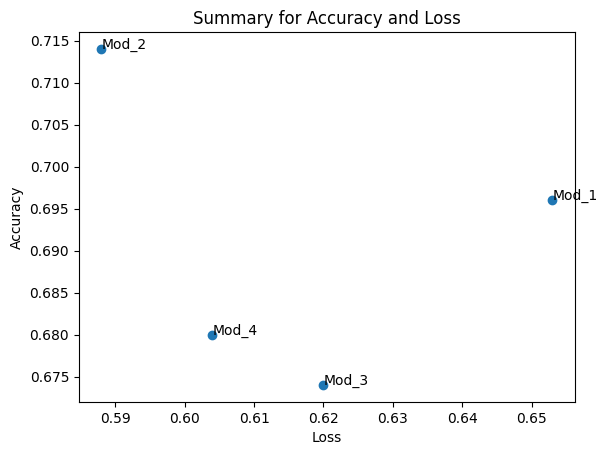

In [ ]:
fig, ax = plt.subplots()
ax.scatter(Loss,Accuracy)
for i, txt in enumerate(Models):
    ax.annotate(txt, (Loss[i],Accuracy[i] ))
plt.title("Summary for Accuracy and Loss")
plt.ylabel("Accuracy")
plt.xlabel("Loss")

plt.show()

<font size="3"><b> Conclusions:</b> From the above graph we can conclude that model 2 is the best amoung all with higher accuracy and minimum loss, however model model 4 has the highest loss </font>

<font size="3"><b> Recommendation:</b> As we can see model 2 is performing best amoung all 4 models hence we should choose model with filters from 32 to 256, 5 Input Layers, Augmented Images and Droput rate of 0.5  </font>

*<font size="4.5"><b> 2. Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch).What performance did you achieve? </b></font>*

<font size="3"><b>Considering Training Sample - 2000 </b></font>

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1250)
make_subset("test", start_index=1500, end_index=1750)

<font size="3"><b>Data Pre-Processing: </b> Using image_dataset_from_directory to read images</font>

In [ ]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


<font size="3">Viewing the size of the images</font>

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


<font size="3"><font size="3">Viewing the size of the images</font></font>

In [ ]:
data_augmentation_1 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.25)
    ]
)

<font size="3"><b>Model - 5 MaxPooling Operation with Increase in filters from 32 to 256 in 5 Input Layers with the data being used from the Augmented Images and a droput rate of 0.5 <u>(Training Sample - 2000)</u></b> </font>

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation_1(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

<font size="3">Training the model 5</font>

In [ ]:

# Compiling the Model
model.compile(loss= "binary_crossentropy",
              optimizer= "adam",
              metrics= ['accuracy'])


# Monitoring the best validation loss using Callbacks
callbacks = ModelCheckpoint(
            filepath = "model5.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Model_5 = model.fit(
          train_dataset,
          epochs= 50,
          validation_data= validation_dataset,
          callbacks= callbacks
          )

Epoch 1/50
63/63 [==============================] - 5s 28ms/step - loss: 0.6929 - accuracy: 0.5080 - val_loss: 0.6919 - val_accuracy: 0.5200
Epoch 2/50
63/63 [==============================] - 1s 22ms/step - loss: 0.6923 - accuracy: 0.5315 - val_loss: 0.6891 - val_accuracy: 0.5060
Epoch 3/50
63/63 [==============================] - 1s 21ms/step - loss: 0.6939 - accuracy: 0.5160 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 4/50
63/63 [==============================] - 1s 22ms/step - loss: 0.6915 - accuracy: 0.5110 - val_loss: 0.6818 - val_accuracy: 0.5400
Epoch 5/50
63/63 [==============================] - 1s 22ms/step - loss: 0.6784 - accuracy: 0.5490 - val_loss: 0.6802 - val_accuracy: 0.5420
Epoch 6/50
63/63 [==============================] - 1s 22ms/step - loss: 0.6753 - accuracy: 0.5820 - val_loss: 0.6553 - val_accuracy: 0.6360
Epoch 7/50
63/63 [==============================] - 1s 22ms/step - loss: 0.6520 - accuracy: 0.6335 - val_loss: 0.6544 - val_accuracy: 0.6360
Epoch 8/50
63

<font size="3">Visualizing the Training and Validation Accuracy/Loss 2</font>

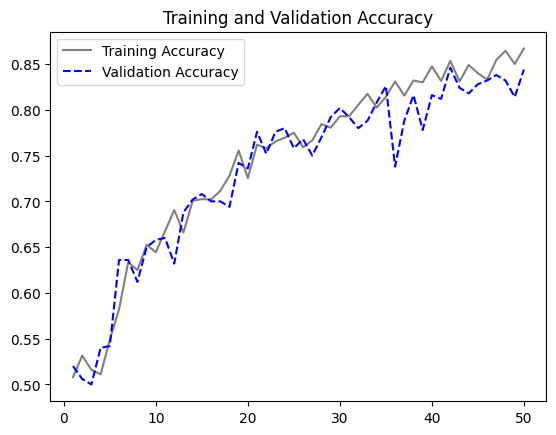

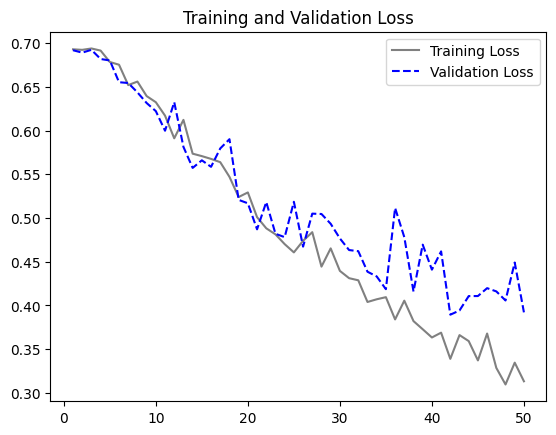

In [ ]:
accuracy = Model_5.history["accuracy"]
val_accuracy = Model_5.history["val_accuracy"]

loss = Model_5.history["loss"]
val_loss = Model_5.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

<font size="3">Evaluating the performance of Model_5 on test set</font>

In [ ]:
best_model = keras.models.load_model("model5.keras")
Model5_Results = best_model.evaluate(test_dataset)
print(f'Loss: {Model5_Results[0]:.3f}')
print(f'Accuracy: {Model5_Results[1]:.3f}')

16/16 [==============================] - 0s 9ms/step - loss: 0.4590 - accuracy: 0.8140
Loss: 0.459
Accuracy: 0.814


<font size="3"> <b>Summary :</b> The second model built just with 1000 training samples resulted in 71% accuracy whereas the same model with an further increase in training samples to 2000 spiked the accuracy to 81% i.e. 10% increase in the accuracy.</font>

<font size="3"><b>Model - 6 Strides Operation with <u>Padding being "Same"</u> with Increase in filters from 32 to 256 in 5 Input Layers with the data being used from the Augmented Images and a droput rate of 0.5 <u>(Training Sample - 2000)</u></b> </font>

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation_1(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(filters=64, kernel_size=3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(filters=128, kernel_size=3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(filters=256, kernel_size=3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(filters=256, kernel_size=3, strides=2, activation="relu", padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_42 (Conv2D)          (None, 90, 90, 32)        896       
                                                                 
 conv2d_43 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 conv2d_44 (Conv2D)          (None, 23, 23, 128)       73856     
                                                                 
 conv2d_45 (Conv2D)          (None, 12, 12, 256)       2951

<font size="3">Training the model 6</font>

In [ ]:
# Compiling the Model
model.compile(loss= "binary_crossentropy",
              optimizer= "adam",
              metrics= ['accuracy'])


# Monitoring the best validation loss using Callbacks
callbacks = ModelCheckpoint(
            filepath = "model6.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Model_6 = model.fit(
          train_dataset,
          epochs= 50,
          validation_data= validation_dataset,
          callbacks= callbacks
          )

Epoch 1/50
63/63 [==============================] - 4s 23ms/step - loss: 0.6951 - accuracy: 0.4830 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 1s 19ms/step - loss: 0.6928 - accuracy: 0.5170 - val_loss: 0.6886 - val_accuracy: 0.5420
Epoch 3/50
63/63 [==============================] - 1s 18ms/step - loss: 0.6932 - accuracy: 0.5140 - val_loss: 0.6929 - val_accuracy: 0.5040
Epoch 4/50
63/63 [==============================] - 1s 18ms/step - loss: 0.6930 - accuracy: 0.5035 - val_loss: 0.6942 - val_accuracy: 0.5040
Epoch 5/50
63/63 [==============================] - 1s 18ms/step - loss: 0.6953 - accuracy: 0.5130 - val_loss: 0.6926 - val_accuracy: 0.5060
Epoch 6/50
63/63 [==============================] - 1s 18ms/step - loss: 0.6941 - accuracy: 0.5065 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/50
63/63 [==============================] - 1s 17ms/step - loss: 0.6942 - accuracy: 0.5045 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 8/50
63

<font size="3">Visualizing the Training and Validation Accuracy/Loss</font>

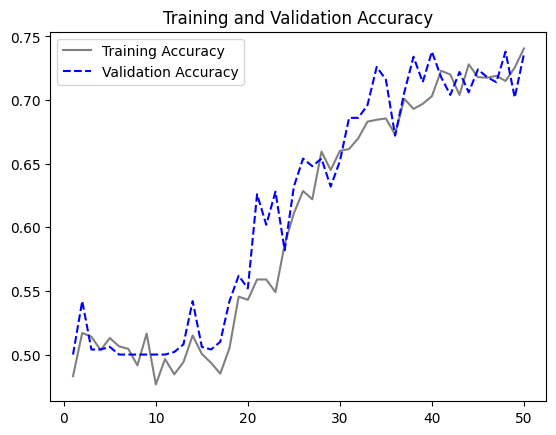

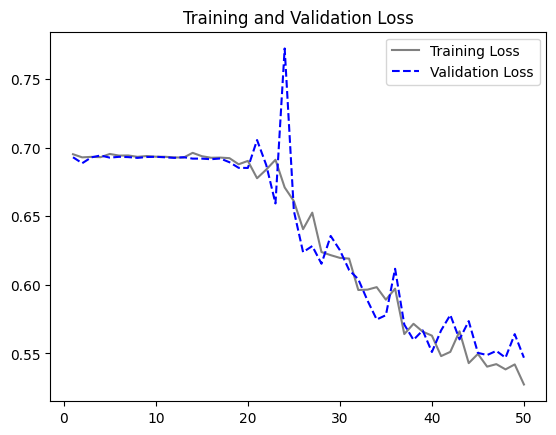

In [ ]:
accuracy = Model_6.history["accuracy"]
val_accuracy = Model_6.history["val_accuracy"]

loss = Model_6.history["loss"]
val_loss = Model_6.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

<font size="3">Evaluating the performance of Model_6 on test set</font>

In [ ]:
best_model = keras.models.load_model("model6.keras")
Model6_Results = best_model.evaluate(test_dataset)
print(f'Loss: {Model6_Results[0]:.3f}')
print(f'Accuracy: {Model6_Results[1]:.3f}')

16/16 [==============================] - 0s 8ms/step - loss: 0.6016 - accuracy: 0.6740
Loss: 0.602
Accuracy: 0.674


<font size="3"><b>Summary for Question 2</b>: We did try to build 2 more models with training sample being 2000. Now lets compare the loss and Accuracy of 3 models to see which model gives better result</font>

<font size="3"><b>Model 2:</b> filters from 32 to 256, 5 Input Layers, Augmented Images and Droput rate of 0.5, training size 1000</font>

<font size="3"><b>Model 5:</b> filters from 32 to 256, 5 Input Layers, Augmented Images and Droput rate of 0.5, <u>training size 2000</u></font>

<font size="3"><b>Model 6:</b> filters from 32 to 256, 5 Input Layers, Augmented Images and Droput rate of 0.5, <u>training size 2000</u>, <u>Padding being same</u> </font>

In [ ]:
Model_5 = (0.459,0.814)
Model_6 = (0.602,0.674)

In [ ]:
Models_2 = ("Mod_2","Mod_5","Mod_6")
Loss_2 = (Model_2[0],Model_5[0],Model_6[0])
Accuracy_2 = (Model_2[1],Model_5[1],Model_6[1])

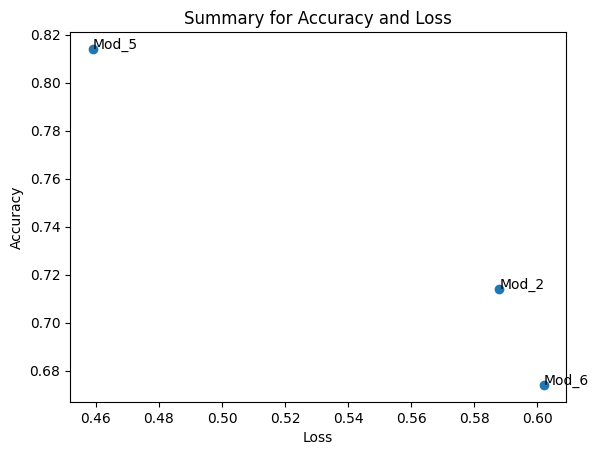

In [ ]:
fig, ax = plt.subplots()
ax.scatter(Loss_2,Accuracy_2)
for i, txt in enumerate(Models_2):
    ax.annotate(txt, (Loss_2[i],Accuracy_2[i] ))
plt.title("Summary for Accuracy and Loss")
plt.ylabel("Accuracy")
plt.xlabel("Loss")

plt.show()

Comparing the performance of the models, it was observed that utilizing strides with padding did not significantly benefit the model. Model 5, incorporating a Max Pooling Layer, exhibited a 14% higher accuracy compared to the Strides model. Furthermore, by optimizing the network and augmenting the training dataset from 1000 to 2000 samples, an enhanced accuracy of 81% was achieved.

To address the second query, we plotted Model 5 and Model 6, allowing a visual comparison of their performance. The graphs distinctly illustrate that Model 5 achieved the highest accuracy among all the models, reaching 81%, with the lowest loss of 45.9%. The augmentation of the training samples to 2000 and the introduction of diverse augmented images notably contributed to the improved performance of the model.

<font size="4.5"><b> *3. Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results *</b></font>

<font size="3"> As we saw in above graph that with the increase in training sample size the Accuracy is also increasing hence will <b>increase the sample size to 3000 and 5000</u> for better performance </font>

<font size="3"><b> Training Sample 3000</b> </font>

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_1")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1000, end_index=1250)
make_subset("test", start_index=1500, end_index=1750)

In [ ]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 3000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


<font size="3"> Using few of the techniques such as random flip, random zoom, random rotation so as to create augmented versions of the image</font>

In [ ]:
data_augmentation_2 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.25)
    ]
)


<font size="3"><b>Model - 7 <u>MaxPooling Operation</u> with Increase in filters from 32 to 256 in 5 Input Layers with the data being used from the Augmented Images and a droput rate of 0.5 <u>(Training Sample - 3000)</u></b> </font>

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation_2(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_47 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

In [ ]:
# Compiling the Model
model.compile(loss= "binary_crossentropy",
              optimizer= "adam",
              metrics= ['accuracy'])


# Monitoring the best validation loss using Callbacks
callbacks = ModelCheckpoint(
            filepath = "model7.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Model_7 = model.fit(
          train_dataset,
          epochs= 50,
          validation_data= validation_dataset,
          callbacks= callbacks
          )

Epoch 1/50
94/94 [==============================] - 5s 26ms/step - loss: 0.6936 - accuracy: 0.5023 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/50
94/94 [==============================] - 2s 21ms/step - loss: 0.6941 - accuracy: 0.4923 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/50
94/94 [==============================] - 2s 20ms/step - loss: 0.6939 - accuracy: 0.4943 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/50
94/94 [==============================] - 2s 20ms/step - loss: 0.6936 - accuracy: 0.5043 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/50
94/94 [==============================] - 2s 20ms/step - loss: 0.6938 - accuracy: 0.4970 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/50
94/94 [==============================] - 2s 20ms/step - loss: 0.6933 - accuracy: 0.4960 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 7/50
94/94 [==============================] - 2s 20ms/step - loss: 0.6938 - accuracy: 0.4967 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 8/50
94

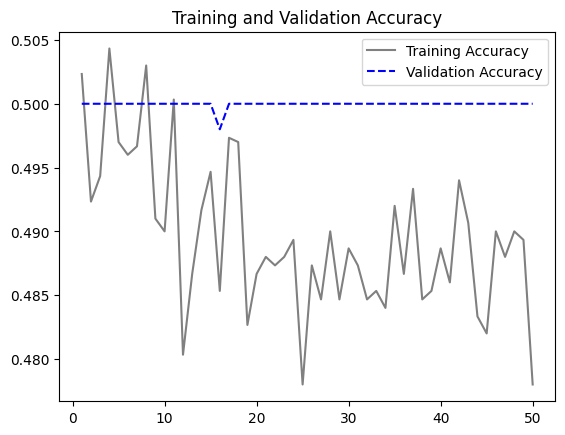

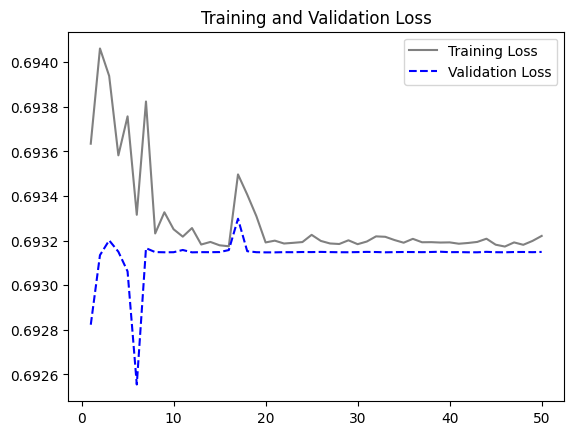

In [ ]:
accuracy = Model_7.history["accuracy"]
val_accuracy = Model_7.history["val_accuracy"]

loss = Model_7.history["loss"]
val_loss = Model_7.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
best_model = keras.models.load_model("model7.keras")
Model7_Results = best_model.evaluate(test_dataset)
print(f'Loss: {Model7_Results[0]:.3f}')
print(f'Accuracy: {Model7_Results[1]:.3f}')

16/16 [==============================] - 0s 9ms/step - loss: 0.6930 - accuracy: 0.5000
Loss: 0.693
Accuracy: 0.500


<font size="3">In the previous Model 6, we attempted to replace the conventional max pooling operation with strides, but the results were not as promising as expected. and in model 7 we used Maxpooling only. Therefore, we are exploring a hybrid approach that combines both max pooling and strides to evaluate the performance of this new model.</font>

<font size="3">Max pooling is a downsampling operation that reduces the spatial dimensions of the feature map, aiming to capture the most prominent features while discarding less relevant information. On the other hand, strides determine the step rate of the sliding window used to extract and learn the features from the data. This hybrid approach aims to leverage the advantages of both techniques, potentially enhancing the model's ability to capture intricate patterns and features while maintaining computational efficiency.</font>

<font size="3"><b>Model - 8 <u>MaxPooling + Strides of Step-Size 2 Operation</u> with Increase in filters from 32 to 256 in 5 Input Layers with the data being used from the Augmented Images and a droput rate of 0.5 (Training Sample - 3000)</u></b> </font>

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation_2(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2,strides=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_10 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_52 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 87, 87, 64)        18496     
                                                          

In [ ]:
# Compiling the Model
model.compile(loss= "binary_crossentropy",
              optimizer= "adam",
              metrics= ['accuracy'])


# Monitoring the best validation loss using Callbacks
callbacks = ModelCheckpoint(
            filepath = "model8.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Model_8 = model.fit(
          train_dataset,
          epochs= 50,
          validation_data= validation_dataset,
          callbacks= callbacks
          )

Epoch 1/50
94/94 [==============================] - 5s 23ms/step - loss: 0.6938 - accuracy: 0.5100 - val_loss: 0.6942 - val_accuracy: 0.5000
Epoch 2/50
94/94 [==============================] - 2s 21ms/step - loss: 0.6936 - accuracy: 0.4983 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 3/50
94/94 [==============================] - 2s 20ms/step - loss: 0.6930 - accuracy: 0.5043 - val_loss: 0.6860 - val_accuracy: 0.5280
Epoch 4/50
94/94 [==============================] - 2s 20ms/step - loss: 0.6941 - accuracy: 0.5357 - val_loss: 0.6895 - val_accuracy: 0.5140
Epoch 5/50
94/94 [==============================] - 2s 21ms/step - loss: 0.6923 - accuracy: 0.5283 - val_loss: 0.6779 - val_accuracy: 0.5960
Epoch 6/50
94/94 [==============================] - 2s 21ms/step - loss: 0.6636 - accuracy: 0.6100 - val_loss: 0.6525 - val_accuracy: 0.6080
Epoch 7/50
94/94 [==============================] - 2s 21ms/step - loss: 0.6574 - accuracy: 0.6167 - val_loss: 0.6636 - val_accuracy: 0.5900
Epoch 8/50
94

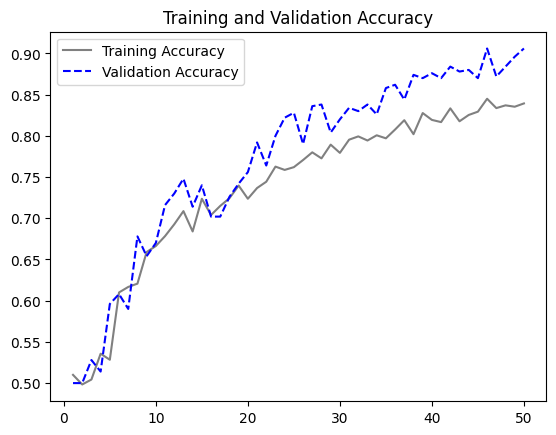

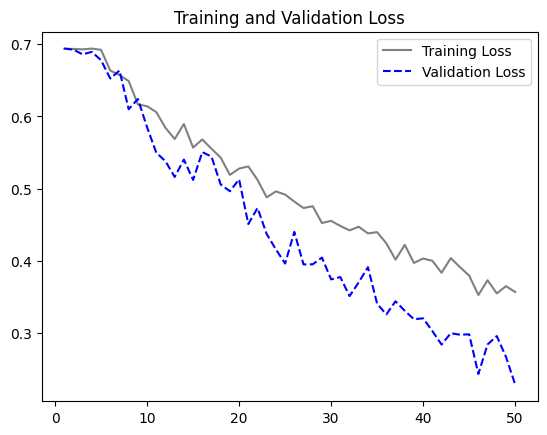

In [ ]:
accuracy = Model_8.history["accuracy"]
val_accuracy = Model_8.history["val_accuracy"]

loss = Model_8.history["loss"]
val_loss = Model_8.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
best_model = keras.models.load_model("model8.keras")
Model8_Results = best_model.evaluate(test_dataset)
print(f'Loss: {Model8_Results[0]:.3f}')
print(f'Accuracy: {Model8_Results[1]:.3f}')

16/16 [==============================] - 1s 9ms/step - loss: 0.4570 - accuracy: 0.8120
Loss: 0.457
Accuracy: 0.812


<font size="3"><b>Model - 9 <u>MaxPooling + Strides of Step-Size 2 with Padding</u> turned on Operation with Increase in filters from 32 to 512 in 5 Input Layers with the data being used from the Augmented Images and a droput rate of 0.5 <u>(Training Sample - 3000)</u></b> </font>

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation_2(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2, padding="same")(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2, padding="same")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2, padding="same")(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2,strides=2, padding="same")(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_11 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_57 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 87, 87, 64)        18496     
                                                          

In [ ]:
# Compiling the Model
model.compile(loss= "binary_crossentropy",
              optimizer= "adam",
              metrics= ['accuracy'])


# Monitoring the best validation loss using Callbacks
callbacks = ModelCheckpoint(
            filepath = "model9.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Model_9 = model.fit(
          train_dataset,
          epochs= 50,
          validation_data= validation_dataset,
          callbacks= callbacks
          )

Epoch 1/50
94/94 [==============================] - 5s 25ms/step - loss: 0.6943 - accuracy: 0.5223 - val_loss: 0.6780 - val_accuracy: 0.6320
Epoch 2/50
94/94 [==============================] - 2s 22ms/step - loss: 0.6781 - accuracy: 0.5660 - val_loss: 0.6625 - val_accuracy: 0.5900
Epoch 3/50
94/94 [==============================] - 2s 20ms/step - loss: 0.6620 - accuracy: 0.6037 - val_loss: 0.7170 - val_accuracy: 0.5360
Epoch 4/50
94/94 [==============================] - 2s 21ms/step - loss: 0.6609 - accuracy: 0.6057 - val_loss: 0.6431 - val_accuracy: 0.6200
Epoch 5/50
94/94 [==============================] - 2s 21ms/step - loss: 0.6372 - accuracy: 0.6393 - val_loss: 0.6812 - val_accuracy: 0.6100
Epoch 6/50
94/94 [==============================] - 2s 20ms/step - loss: 0.6213 - accuracy: 0.6593 - val_loss: 0.6584 - val_accuracy: 0.5500
Epoch 7/50
94/94 [==============================] - 2s 21ms/step - loss: 0.6136 - accuracy: 0.6707 - val_loss: 0.5720 - val_accuracy: 0.6980
Epoch 8/50
94

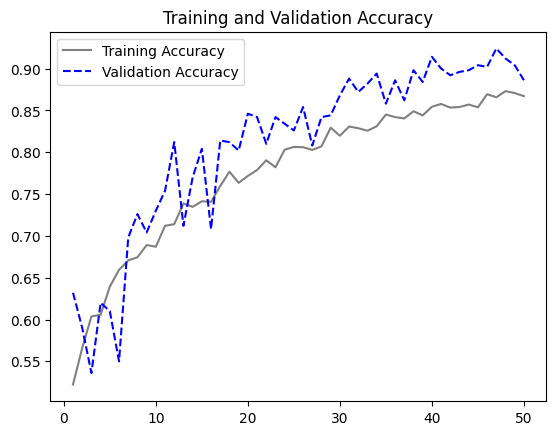

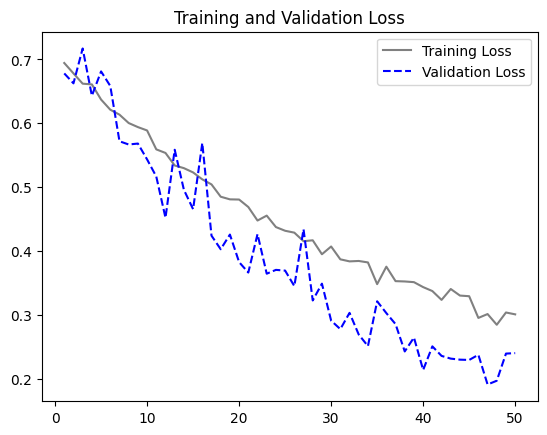

In [ ]:
accuracy = Model_9.history["accuracy"]
val_accuracy = Model_9.history["val_accuracy"]

loss = Model_9.history["loss"]
val_loss = Model_9.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
best_model = keras.models.load_model("model9.keras")
Model9_Results = best_model.evaluate(test_dataset)
print(f'Loss: {Model9_Results[0]:.3f}')
print(f'Accuracy: {Model9_Results[1]:.3f}')

16/16 [==============================] - 0s 9ms/step - loss: 0.4086 - accuracy: 0.8320
Loss: 0.409
Accuracy: 0.832


<font size="3">Let's see which of the models have best performance when the training sample was set to 3000. Note: Here models 8 and 9 were trained differently with strides being used with maxpooling and strides being used with maxpooling and padding turned on.</font>

<font size="3"><b>Model 6:</b> trides Operation with Padding being "Same" ,filters from 32 to 512, 5 Input Layers, droput rate of 0.5, Training Sample - 3000</font>

<font size="3"><b>Model 7:</b> MaxPooling Operation,filters from 32 to 512, 5 Input Layers, droput rate of 0.5, Training Sample - 3000</font>

<font size="3"><b>Model 8:</b> MaxPooling + Strides of Step-Size 2,filters from 32 to 512, 5 Input Layers, droput rate of 0.5, Training Sample - 3000</font>

<font size="3"><b>Model 9:</b> MaxPooling + Strides of Step-Size 2 with Padding turned on,filters from 32 to 512, 5 Input Layers, droput rate of 0.5, Training Sample - 3000 </font>

In [ ]:
Model_7 = (0.69,0.500)
Model_8 = (0.457,0.812)
Model_9 = (0.409,0.832)

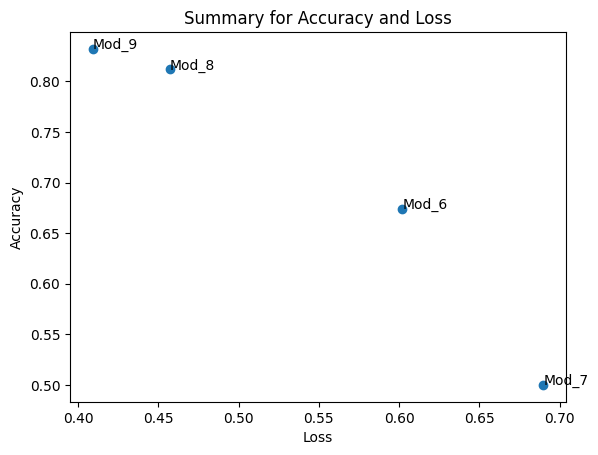

In [ ]:
Models_3 = ("Mod_6","Mod_7","Mod_8","Mod_9")
Loss_3 = (Model_6[0],Model_7[0],Model_8[0],Model_9[0])
Accuracy_3 = (Model_6[1],Model_7[1],Model_8[1],Model_9[1])

fig, ax = plt.subplots()
ax.scatter(Loss_3,Accuracy_3)
for i, txt in enumerate(Models_3):
    ax.annotate(txt, (Loss_3[i],Accuracy_3[i] ))
plt.title("Summary for Accuracy and Loss")
plt.ylabel("Accuracy")
plt.xlabel("Loss")

plt.show()

Here we can clearly see that the model which was built with 5 layers using maxpooling along with strides and padding on was giving the highest accuracy i.e. 83.2 % with least loss amoung the other 2 models i.e. 40.9%.

Now, we are increasing the training sample to 5000 and building a model from scratch to check it's performance on the unseen data.

<font size="3"><b>Training Sample - 5000<b></font>

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=2500)
make_subset("validation", start_index=1000, end_index=1250)
make_subset("test", start_index=1500, end_index=1750)

In [ ]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 5000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [ ]:
data_augmentation_3 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.25)
    ]
)

<font size="3"><b>Model - 10 MaxPooling Operation with Increase in filters from 32 to 256 in 5 Input Layers with the data being used from the Augmented Images and a droput rate of 0.5 <u>(Training Sample - 5000)</u></b> </font>

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation_3(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_12 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_62 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_63 (Conv2D)          (None, 87, 87, 64)        18496     
                                                          

In [ ]:
# Compiling the Model
model.compile(loss= "binary_crossentropy",
              optimizer= "adam",
              metrics= ['accuracy'])


# Monitoring the best validation loss using Callbacks
callbacks = ModelCheckpoint(
            filepath = "model10.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Model_10 = model.fit(
          train_dataset,
          epochs= 50,
          validation_data= validation_dataset,
          callbacks= callbacks
          )

Epoch 1/50
157/157 [==============================] - 6s 21ms/step - loss: 0.6934 - accuracy: 0.5148 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 2/50
157/157 [==============================] - 3s 19ms/step - loss: 0.6908 - accuracy: 0.5260 - val_loss: 0.6608 - val_accuracy: 0.6600
Epoch 3/50
157/157 [==============================] - 3s 19ms/step - loss: 0.6802 - accuracy: 0.5706 - val_loss: 0.6825 - val_accuracy: 0.5000
Epoch 4/50
157/157 [==============================] - 3s 19ms/step - loss: 0.6852 - accuracy: 0.5400 - val_loss: 0.6672 - val_accuracy: 0.5940
Epoch 5/50
157/157 [==============================] - 3s 19ms/step - loss: 0.6770 - accuracy: 0.5682 - val_loss: 0.6569 - val_accuracy: 0.6400
Epoch 6/50
157/157 [==============================] - 3s 19ms/step - loss: 0.6565 - accuracy: 0.6278 - val_loss: 0.6322 - val_accuracy: 0.6480
Epoch 7/50
157/157 [==============================] - 3s 19ms/step - loss: 0.6295 - accuracy: 0.6506 - val_loss: 0.5962 - val_accuracy: 0.6860

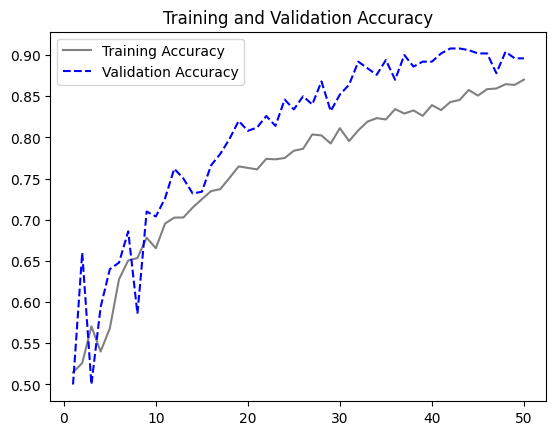

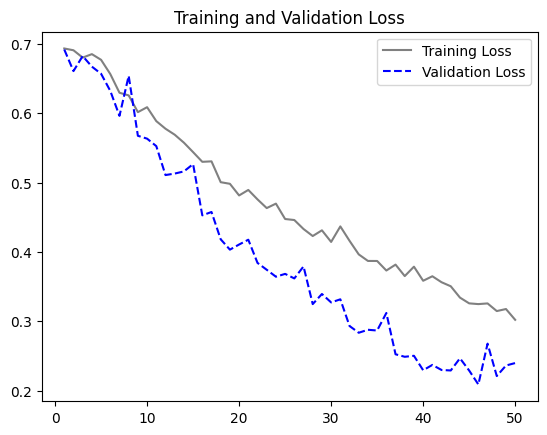

In [ ]:
accuracy = Model_10.history["accuracy"]
val_accuracy = Model_10.history["val_accuracy"]

loss = Model_10.history["loss"]
val_loss = Model_10.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
best_model = keras.models.load_model("model10.keras")
Model10_Results = best_model.evaluate(test_dataset)
print(f'Loss: {Model10_Results[0]:.3f}')
print(f'Accuracy: {Model10_Results[1]:.3f}')

16/16 [==============================] - 0s 10ms/step - loss: 0.2834 - accuracy: 0.8840
Loss: 0.283
Accuracy: 0.884


<font size="3"><b>Summary for Question 3</b>, we constructed four models, three of which were trained with a sample size of 3000. The top-performing model achieved an 83.2% accuracy. Notably, when we expanded the training sample to 5000, the accuracy rose to 88.4%. Consequently, we deduce that increasing the training sample to 5000 substantially enhances the model's performance.Regarding the plausible reason for the validation loss being lower than the training loss, it is likely influenced by the adopted split strategy. In this case, the training sample is nearly as extensive as 5000, while the validation and test sets remain fixed at 500 each. Additionally, it is essential to acknowledge that during training, regularizations such as dropout or L1 and L2 regularizers play a significant role, contributing to the computation of the training loss. Conversely, during the validation or test phase, these regularizers are disabled, potentially leading to a lower loss compared to the training loss.</font>

*<font size="4.5"><b> 4. Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance </b></font>*

<font size="4.5"><b> Leveraging a Pre-Trained Model - VGG16 </b></font>

<font size="4.5"><b> VGG - Model 1 (1000 Training Samples) </b></font>

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
#extracting VGG 16 features and Labels
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 23ms/step


In [ ]:
train_features.shape

(5000, 5, 5, 512)

<font size="4.5"><b> VGG - Model 1 Dense Layer with 256 Nodes and Droput Rate of 0.5 and optimizer being rmsprop with the Original Images</b></font>

In [ ]:
# Defining and Training the densely connected classifier
# The last dense stacked layer and the classifier
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)


# Compiling the Model
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


# Using CallBacks to monitor the best val_loss
callbacks = ModelCheckpoint(
            filepath="vgg_model1.keras",
            save_best_only=True,
            monitor="val_loss")


# Model Fit
VGG_Model_1 = model.fit(
              train_features, train_labels,
              epochs= 30,
              validation_data= (val_features, val_labels),
              callbacks= callbacks)

Epoch 1/30
157/157 [==============================] - 2s 5ms/step - loss: 11.3170 - accuracy: 0.9444 - val_loss: 0.5029 - val_accuracy: 0.9900
Epoch 2/30
157/157 [==============================] - 1s 4ms/step - loss: 2.9963 - accuracy: 0.9810 - val_loss: 0.1466 - val_accuracy: 0.9980
Epoch 3/30
157/157 [==============================] - 1s 3ms/step - loss: 1.2910 - accuracy: 0.9908 - val_loss: 2.4968 - val_accuracy: 0.9800
Epoch 4/30
157/157 [==============================] - 1s 4ms/step - loss: 1.5284 - accuracy: 0.9888 - val_loss: 1.9570e-08 - val_accuracy: 1.0000
Epoch 5/30
157/157 [==============================] - 1s 4ms/step - loss: 0.9568 - accuracy: 0.9922 - val_loss: 1.6928e-15 - val_accuracy: 1.0000
Epoch 6/30
157/157 [==============================] - 1s 4ms/step - loss: 0.9920 - accuracy: 0.9924 - val_loss: 1.5836e-21 - val_accuracy: 1.0000
Epoch 7/30
157/157 [==============================] - 1s 4ms/step - loss: 0.8880 - accuracy: 0.9940 - val_loss: 0.0336 - val_accuracy: 

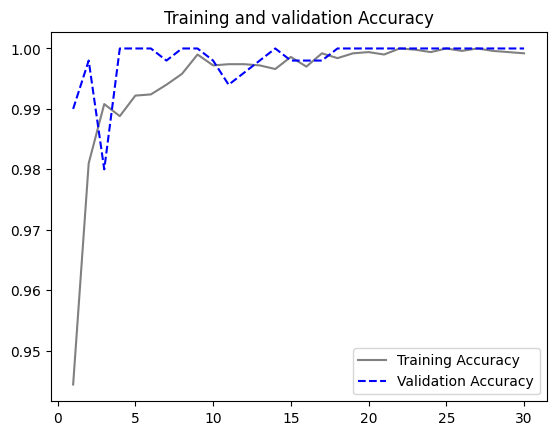

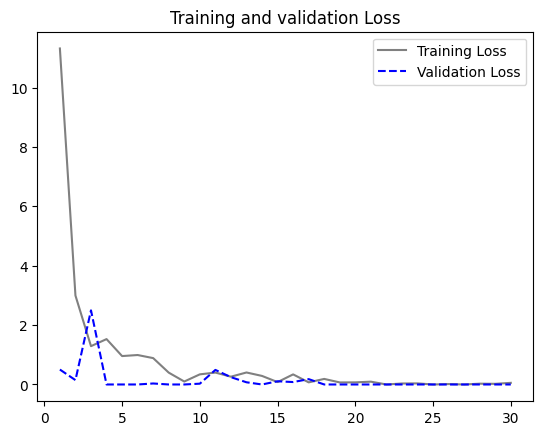

In [ ]:
acc = VGG_Model_1.history["accuracy"]
val_acc = VGG_Model_1.history["val_accuracy"]

loss = VGG_Model_1.history["loss"]
val_loss = VGG_Model_1.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color="grey", label="Training Accuracy")
plt.plot(epochs, val_acc, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and validation Loss")
plt.legend()
plt.show()

In [ ]:
best_model = keras.models.load_model("vgg_model1.keras")
VGG_Model_1_Results = best_model.evaluate(test_features,test_labels)
print(f'Loss: {VGG_Model_1_Results[0]:.3f}')
print(f'Accuracy: {VGG_Model_1_Results[1]:.3f}')

16/16 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Loss: 0.000
Accuracy: 1.000


<font size="4.5"><b> VGG - Model 2 (1000 Training Samples) </b></font>

We have configured the pre-trained model to retain its existing weights during training, only allowing the densely connected networks and the classifier to adjust their weights during the training process.

This approach helps prevent overfitting as the pre-trained model remains unchanged, providing a stable foundation for the model. Moreover, when dealing with limited training data and constrained computational resources, freezing the pre-trained model training can be particularly advantageous.

To illustrate the impact of this configuration, we can print the list of trainable weights both before and after freezing the pre-trained model.

In [ ]:
# Before Freezing
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [ ]:
# After Freezing
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

<font size="4.5"><b> VGG - Model 2 Dense Layer with 256 Nodes and Droput Rate of 0.5 and optimizer being rmsprop with the Augmented Images</b></font>

In [ ]:
# Data Augmentation -Adding a data augmentation stage to provide augmented training samples and a classifier to the convolutional base
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

# Adding the Classifier and Dense Network
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)


In [ ]:
# Compiling the Model
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Using CallBacks to monitor the best val_loss
callbacks = ModelCheckpoint(
            filepath= "vgg_model2.keras",
            save_best_only= True,
            monitor= "val_loss")

# Model Fit
VGG_Model_2 = model.fit(
              train_dataset,
              epochs= 30,
              validation_data=validation_dataset,
              callbacks=callbacks)

Epoch 1/30
157/157 [==============================] - 8s 40ms/step - loss: 11.6774 - accuracy: 0.9264 - val_loss: 5.8878 - val_accuracy: 0.9660
Epoch 2/30
157/157 [==============================] - 6s 39ms/step - loss: 6.1833 - accuracy: 0.9514 - val_loss: 3.8140 - val_accuracy: 0.9800
Epoch 3/30
157/157 [==============================] - 6s 39ms/step - loss: 4.7273 - accuracy: 0.9594 - val_loss: 2.3475 - val_accuracy: 0.9760
Epoch 4/30
157/157 [==============================] - 6s 39ms/step - loss: 3.2261 - accuracy: 0.9634 - val_loss: 2.0974 - val_accuracy: 0.9820
Epoch 5/30
157/157 [==============================] - 6s 39ms/step - loss: 3.1476 - accuracy: 0.9654 - val_loss: 0.5457 - val_accuracy: 0.9900
Epoch 6/30
157/157 [==============================] - 6s 37ms/step - loss: 2.1593 - accuracy: 0.9648 - val_loss: 0.5819 - val_accuracy: 0.9860
Epoch 7/30
157/157 [==============================] - 6s 37ms/step - loss: 1.6923 - accuracy: 0.9706 - val_loss: 1.0481 - val_accuracy: 0.984

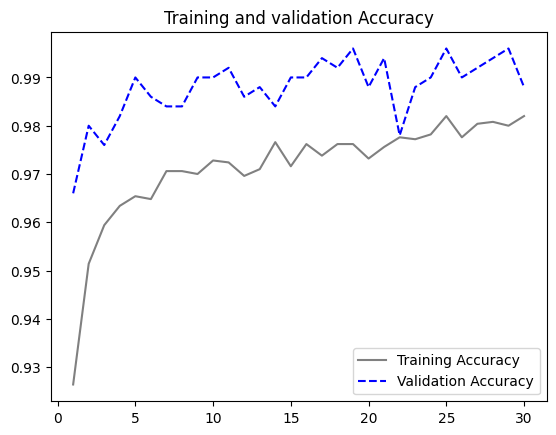

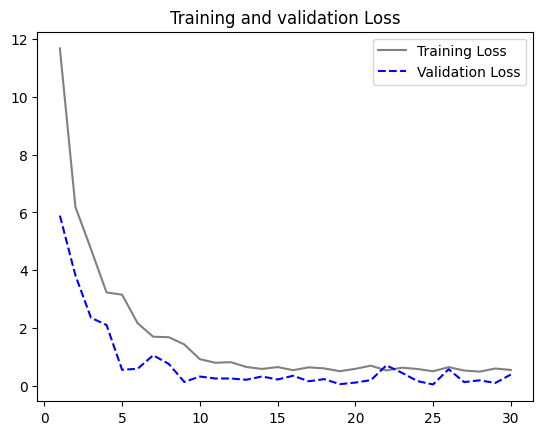

In [ ]:
acc = VGG_Model_2.history["accuracy"]
val_acc = VGG_Model_2.history["val_accuracy"]

loss = VGG_Model_2.history["loss"]
val_loss = VGG_Model_2.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color="grey", label="Training Accuracy")
plt.plot(epochs, val_acc, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and validation Loss")
plt.legend()
plt.show()

In [ ]:
best_model = keras.models.load_model("vgg_model2.keras")
VGG_Model_2_Results= best_model.evaluate(test_dataset)
print(f'Loss: {VGG_Model_2_Results[0]:.3f}')
print(f'Accuracy: {VGG_Model_2_Results[1]:.3f}')

16/16 [==============================] - 1s 31ms/step - loss: 0.0260 - accuracy: 0.9980
Loss: 0.026
Accuracy: 0.998


<font size="4.5"><b> Fine Tuning the VGG_Model_2</b></font>

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

<font size="4.5">It is crucial to understand that pre-trained networks are not solely utilized for singular image classification tasks; rather, they are trained to handle diverse use cases and classifications. The initial layers of the network are adept at capturing general features, while the subsequent layers tend to specialize in extracting features specific to the problem at hand. When we opt to freeze the initial layers, we effectively prevent overfitting, enabling the model to assimilate more intricate details pertaining to our specific classification task. This strategic approach encourages the model to focus on learning the nuanced aspects of the target classification problem.</font>

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])


callbacks = ModelCheckpoint(
            filepath="fine_tuning_vgg_model2.keras",
            save_best_only=True,
            monitor="val_loss")


FineTuned_VGG_Model_2 = model.fit(
                        train_dataset,
                        epochs=30,
                        validation_data=validation_dataset,
                        callbacks=callbacks)

Epoch 1/30
157/157 [==============================] - 9s 44ms/step - loss: 0.5814 - accuracy: 0.9812 - val_loss: 0.1324 - val_accuracy: 0.9920
Epoch 2/30
157/157 [==============================] - 7s 41ms/step - loss: 0.3211 - accuracy: 0.9838 - val_loss: 0.2911 - val_accuracy: 0.9900
Epoch 3/30
157/157 [==============================] - 7s 41ms/step - loss: 0.4245 - accuracy: 0.9828 - val_loss: 0.1409 - val_accuracy: 0.9960
Epoch 4/30
157/157 [==============================] - 7s 41ms/step - loss: 0.2823 - accuracy: 0.9856 - val_loss: 0.1580 - val_accuracy: 0.9960
Epoch 5/30
157/157 [==============================] - 7s 42ms/step - loss: 0.2966 - accuracy: 0.9868 - val_loss: 0.0682 - val_accuracy: 0.9980
Epoch 6/30
157/157 [==============================] - 7s 41ms/step - loss: 0.2301 - accuracy: 0.9866 - val_loss: 0.0912 - val_accuracy: 0.9960
Epoch 7/30
157/157 [==============================] - 7s 41ms/step - loss: 0.1625 - accuracy: 0.9888 - val_loss: 0.0850 - val_accuracy: 0.9980

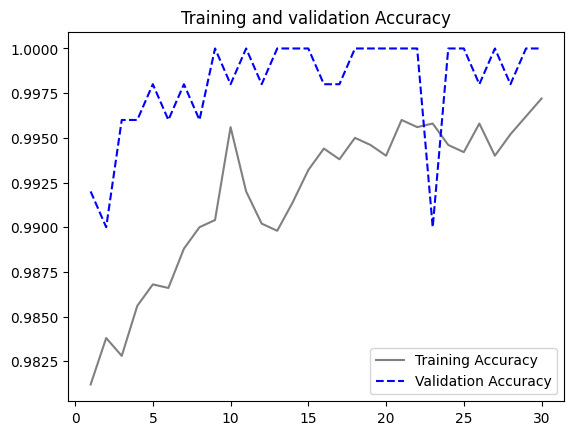

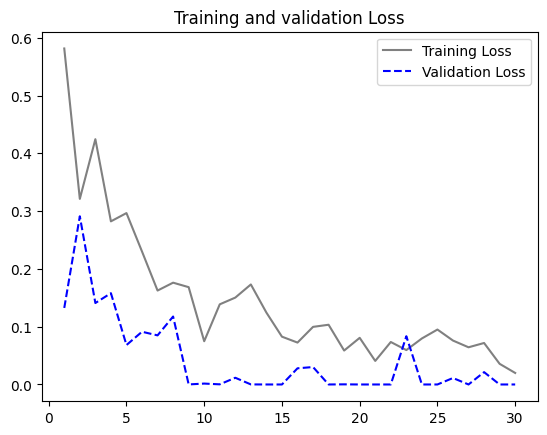

In [ ]:
acc = FineTuned_VGG_Model_2.history["accuracy"]
val_acc = FineTuned_VGG_Model_2.history["val_accuracy"]

loss = FineTuned_VGG_Model_2.history["loss"]
val_loss = FineTuned_VGG_Model_2.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color="grey", label="Training Accuracy")
plt.plot(epochs, val_acc, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and validation Loss")
plt.legend()
plt.show()

In [ ]:
best_model = keras.models.load_model("fine_tuning_vgg_model2.keras")
FineTuned_VGG_Model_2_Results = best_model.evaluate(test_dataset)
print(f"Loss: {FineTuned_VGG_Model_2_Results[0]:.3f}")
print(f"Accuracy: {FineTuned_VGG_Model_2_Results[1]:.3f}")

16/16 [==============================] - 1s 31ms/step - loss: 4.7333e-08 - accuracy: 1.0000
Loss: 0.000
Accuracy: 1.000


<font size="4.5"> In above 2 VGG16 models analysis, we constructed three models utilizing the pre-trained network VGG16. Notably, we observed that preventing the pre-trained network from updating its weights during training, and subsequently freezing the initial layers of the pre-trained network, resulted in higher accuracy. Consequently, we aim to employ the same methodology in building two models using a training sample size of 5000.

<font size="4.5"><b> VGG - Model 3 (5000 Training Samples) </b></font>

In [ ]:
conv_base= keras.applications.vgg16.VGG16(
           weights="imagenet",
           include_top=False)

conv_base.trainable = False


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 5000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [ ]:
# Data Augmentation
data_augmentation_4 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.25),
    ]
)

# Adding the Classifier and Dense Network
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation_4(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

# Compiling the Model
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Using CallBacks to monitor the best val_loss
callbacks = ModelCheckpoint(
            filepath= "vgg_model3.keras",
            save_best_only= True,
            monitor= "val_loss")

# Model Fit
VGG_Model_3 = model.fit(
              train_dataset,
              epochs= 50,
              validation_data=validation_dataset,
              callbacks=callbacks)

Epoch 1/50
157/157 [==============================] - 8s 41ms/step - loss: 10.5988 - accuracy: 0.9154 - val_loss: 1.8303 - val_accuracy: 0.9860
Epoch 2/50
157/157 [==============================] - 6s 40ms/step - loss: 6.1195 - accuracy: 0.9448 - val_loss: 0.8026 - val_accuracy: 0.9860
Epoch 3/50
157/157 [==============================] - 6s 38ms/step - loss: 4.1963 - accuracy: 0.9504 - val_loss: 1.0276 - val_accuracy: 0.9840
Epoch 4/50
157/157 [==============================] - 6s 40ms/step - loss: 2.2763 - accuracy: 0.9618 - val_loss: 0.1023 - val_accuracy: 0.9960
Epoch 5/50
157/157 [==============================] - 6s 38ms/step - loss: 1.9037 - accuracy: 0.9580 - val_loss: 0.2311 - val_accuracy: 0.9940
Epoch 6/50
157/157 [==============================] - 6s 40ms/step - loss: 0.9389 - accuracy: 0.9644 - val_loss: 0.0859 - val_accuracy: 0.9960
Epoch 7/50
157/157 [==============================] - 6s 38ms/step - loss: 0.6627 - accuracy: 0.9674 - val_loss: 0.1129 - val_accuracy: 0.996

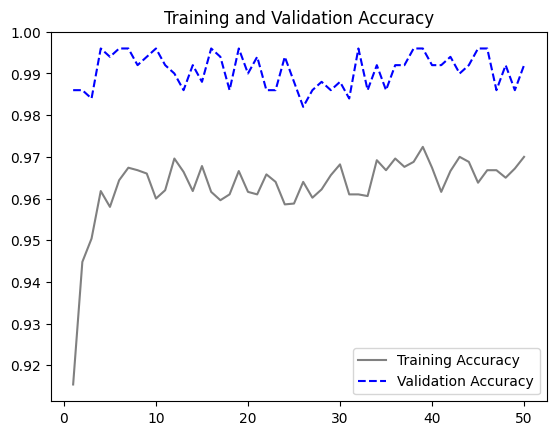

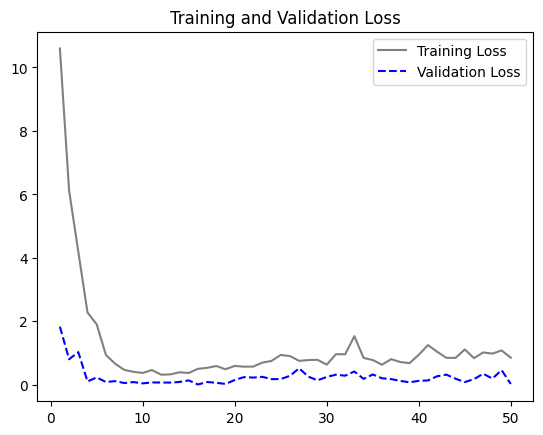

In [ ]:
acc = VGG_Model_3.history["accuracy"]
val_acc = VGG_Model_3.history["val_accuracy"]

loss = VGG_Model_3.history["loss"]
val_loss = VGG_Model_3.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color="grey", label="Training Accuracy")
plt.plot(epochs, val_acc, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
best_model = keras.models.load_model("vgg_model3.keras")
VGG_Model_3_Results = best_model.evaluate(test_dataset)
print(f"Loss: {VGG_Model_3_Results[0]:.3f}")
print(f"Accuracy: {VGG_Model_3_Results[1]:.3f}")

16/16 [==============================] - 1s 32ms/step - loss: 0.1335 - accuracy: 0.9840
Loss: 0.134
Accuracy: 0.984


<font size="4.5"><b> Fine Tunning VGG_Model_3 (Training Samples - 5000)</b></font>

<font size="4.5">In our efforts to optimize VGG_Model3, we have chosen to freeze the initial four layers. This strategy aims to prevent the model from overfitting and allows it to concentrate solely on learning the distinctive features relevant to our particular classification task.Consequently, we have configured the pre-trained layers to remain unaltered during training, while simultaneously ensuring that the first four layers remain frozen. These optimizations are instrumental in enhancing the model's performance when dealing with a training sample size of 5000.</font>

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              metrics=["accuracy"])


callbacks = ModelCheckpoint(
            filepath="fine_tuning_vgg_model3.keras",
            save_best_only=True,
            monitor="val_loss")


FineTuned_VGG_Model_3 = model.fit(
                        train_dataset,
                        epochs=50,
                        validation_data=validation_dataset,
                        callbacks=callbacks)

Epoch 1/50
157/157 [==============================] - 10s 44ms/step - loss: 0.6214 - accuracy: 0.9730 - val_loss: 0.1435 - val_accuracy: 0.9880
Epoch 2/50
157/157 [==============================] - 7s 43ms/step - loss: 0.5057 - accuracy: 0.9704 - val_loss: 0.0525 - val_accuracy: 0.9920
Epoch 3/50
157/157 [==============================] - 7s 41ms/step - loss: 0.3409 - accuracy: 0.9768 - val_loss: 0.0897 - val_accuracy: 0.9960
Epoch 4/50
157/157 [==============================] - 7s 41ms/step - loss: 0.3513 - accuracy: 0.9760 - val_loss: 0.1144 - val_accuracy: 0.9960
Epoch 5/50
157/157 [==============================] - 7s 44ms/step - loss: 0.2530 - accuracy: 0.9808 - val_loss: 0.0221 - val_accuracy: 0.9980
Epoch 6/50
157/157 [==============================] - 7s 42ms/step - loss: 0.2061 - accuracy: 0.9836 - val_loss: 0.0499 - val_accuracy: 0.9960
Epoch 7/50
157/157 [==============================] - 7s 42ms/step - loss: 0.1904 - accuracy: 0.9840 - val_loss: 0.0526 - val_accuracy: 0.996

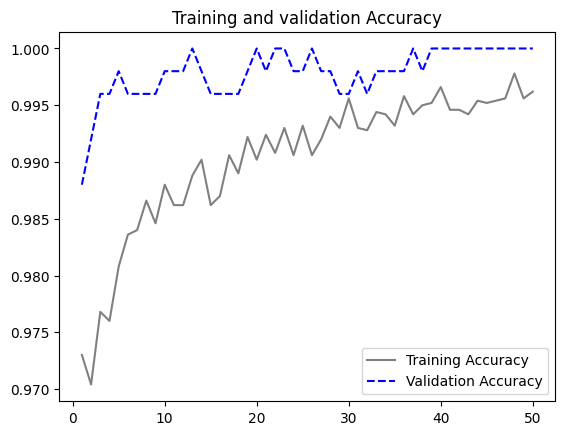

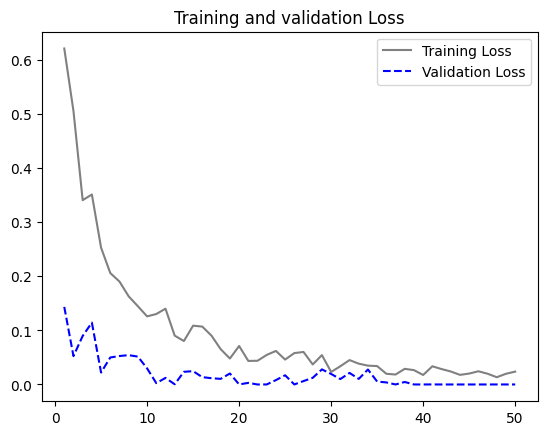

In [ ]:
acc = FineTuned_VGG_Model_3.history["accuracy"]
val_acc = FineTuned_VGG_Model_3.history["val_accuracy"]

loss = FineTuned_VGG_Model_3.history["loss"]
val_loss = FineTuned_VGG_Model_3.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color="grey", label="Training Accuracy")
plt.plot(epochs, val_acc, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and validation Loss")
plt.legend()
plt.show()

In [ ]:
best_model = keras.models.load_model("fine_tuning_vgg_model3.keras")
FineTuned_VGG_Model_3_Results = best_model.evaluate(test_dataset)
print(f"Loss: {FineTuned_VGG_Model_3_Results[0]:.3f}")
print(f"Accuracy: {FineTuned_VGG_Model_3_Results[1]:.3f}")

16/16 [==============================] - 1s 32ms/step - loss: 1.5571e-08 - accuracy: 1.0000
Loss: 0.000
Accuracy: 1.000


<font size="4.5">Now, having constructed a total of 15 models, with two models serving as fine-tuned versions of the initial ones, we are poised to conduct a comparative analysis to determine the best-performing models in two distinct categories: Scratch Models and Pre-Trained Models. Our immediate focus is to evaluate the best model developed from scratch. This evaluation entails comparing the loss and accuracy metrics of the 10 models built across four different training samples. The primary objective is to ascertain the optimal training sample size for the task of classifying cats and dogs.<font>

<font size="3"><b>Model 1:</b> filters from 32 to 256, 5 Input Layers</font>

<font size="3"><b>Model 2:</b> filters from 32 to 256, 5 Input Layers, Augmented Images and Droput rate of 0.5</font>

<font size="3"><b>Model 3:</b> <u>filters from 32 to 512, 6 Input Layers</u>, Augmented Images and Dropout rate of 0.5</font>

<font size="3"><b>Model 4:</b> <u>filters from 64 to 1024</u>, 5 Input Layers, Augmented Images and Dropout rate of 0.6 </font>

<font size="3"><b>Model 5:</b> filters from 32 to 256, 5 Input Layers, Augmented Images and Droput rate of 0.5, <u>training size 2000</u></font>

<font size="3"><b>Model 6:</b> filters from 32 to 256, 5 Input Layers, Augmented Images and Droput rate of 0.5, <u>training size 2000</u>, <u>Padding being same</u> </font>

<font size="3"><b>Model 7:</b> MaxPooling Operation,filters from 32 to 512, 5 Input Layers, Augmented Images, droput rate of 0.5, <u>Training Sample - 3000</u></font>

<font size="3"><b>Model 8:</b> <u>MaxPooling + Strides of Step-Size 2</u>,filters from 32 to 512, 5 Input Layers, Augmented Images, droput rate of 0.5, <u>Training Sample - 3000</u></font>

<font size="3"><b>Model 9:</b> <u>MaxPooling + Strides of Step-Size 2 with Padding turned on</u>,filters from 32 to 512, 5 Input Layers,Augmented Images, droput rate of 0.5, <u>Training Sample - 3000</u> </font>
    
<font size="3"><b>Model 10:</b> filters from 32 to 512, 5 Input Layers,Augmented Images, droput rate of 0.5, <u>Training Sample - 5000</u> </font>

In [ ]:
# Scratch Models
Model_1 = (0.653, 0.696)
Model_2 = (0.588, 0.714)
Model_3 = (0.620,0.674)
Model_4 = (0.604, 0.680)
Model_5 = (0.459,0.814)
Model_6 = (0.602,0.674)
Model_7 = (0.69,0.500)
Model_8 = (0.457,0.812)
Model_9 = (0.409,0.832)
Model_10 = (0.283,0.884)

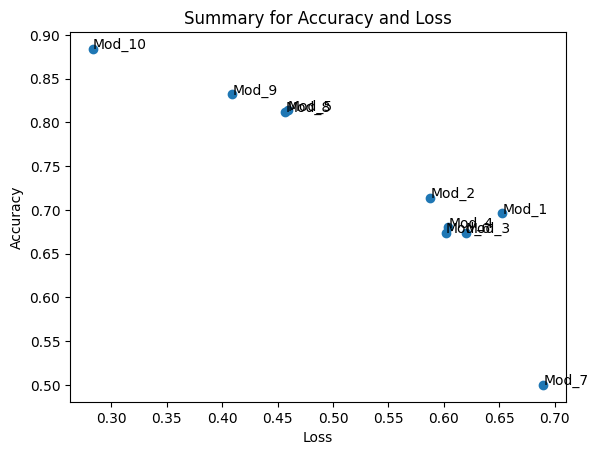

In [ ]:
Models_4 = ("Mod_1","Mod_2","Mod_3","Mod_4","Mod_5","Mod_6","Mod_7","Mod_8","Mod_9","Mod_10")
Loss_4 = (Model_1[0],Model_2[0],Model_3[0],Model_4[0],Model_5[0],Model_6[0],Model_7[0],Model_8[0],Model_9[0],Model_10[0])
Accuracy_4 = (Model_1[1],Model_2[1],Model_3[1],Model_4[1],Model_5[1],Model_6[1],Model_7[1],Model_8[1],Model_9[1],Model_10[1])

fig, ax = plt.subplots()
ax.scatter(Loss_4,Accuracy_4)
for i, txt in enumerate(Models_4):
    ax.annotate(txt, (Loss_4[i],Accuracy_4[i] ))
plt.title("Summary for Accuracy and Loss")
plt.ylabel("Accuracy")
plt.xlabel("Loss")

plt.show()

<font size="4.5"><b>Regarding the scratch models, Model_10, trained with 5000 samples, emerged as the top-performing model, exhibiting a notable 88.4% accuracy and a 28.3% loss on the test set. Model_10 was constructed using a five-layer architecture, incorporating filters ranging from 32 to 256. The model was enhanced with a max-pooling layer and a dropout rate of 0.5, with the integration of augmented images during the training process.<b><font>

<font size="3">Next we built 5 models using the pre-trained vgg16 network, the first 3 were built using 1000 as sample and rmsprop as optimizer and the next 2 where built using 5000 as sample size and adam as optimizer<font>
    
<font size="3"><b>VGG 1:</b> filters from 32 to 256, 5 Input Layers</font>

<font size="3"><b>VGG 2:</b> filters from 32 to 256, 5 Input Layers, Augmented Images and Droput rate of 0.5</font>

<font size="3"><b>VGG 3:</b> <u>filters from 32 to 512, 6 Input Layers</u>, Augmented Images and Dropout rate of 0.5</font>

<font size="3"><b>VGG 4:</b> VGG - Model 3 (5000 Training Samples) </font>

<font size="3"><b>VGG 5:</b> Fine Tunning VGG_Model_3 (Training Samples - 5000)</font>


In [ ]:
# Pre-Trained Models
VGG_Model_1 = (0.00,100)
VGG_Model_2 = (2.6,99.8)
FineTuned_VGG_Model_2 = (0.00,100)
VGG_Model_3 = (13.4,98.4)
FineTuned_VGG_Model_3 = (0.00,100)

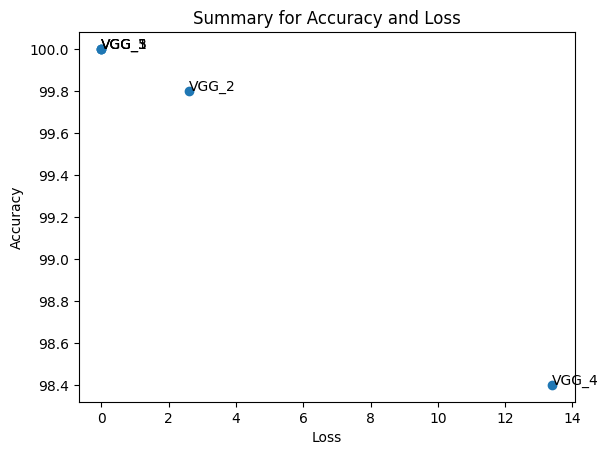

In [ ]:
Models_5 = ("VGG_1","VGG_2","VGG_3","VGG_4","VGG_5")
Loss_5 = (VGG_Model_1[0],VGG_Model_2[0],FineTuned_VGG_Model_2[0],VGG_Model_3[0],FineTuned_VGG_Model_3[0])
Accuracy_5 = (VGG_Model_1[1],VGG_Model_2[1],FineTuned_VGG_Model_2[1],VGG_Model_3[1],FineTuned_VGG_Model_3[1])

fig, ax = plt.subplots()
ax.scatter(Loss_5,Accuracy_5)
for i, txt in enumerate(Models_5):
    ax.annotate(txt, (Loss_5[i],Accuracy_5[i] ))
plt.title("Summary for Accuracy and Loss")
plt.ylabel("Accuracy")
plt.xlabel("Loss")

plt.show()

<font size="3">In the realm of pre-trained models, it was Model_5 and model_3, or the FineTuned_VGG_Model_2 and FineTuned_VGG_Model_3, that stood out as the top performer, boasting an impressive 100% accuracy and a mere 0.00% loss. Constructed with 2000 and 5000 training samples, this model was optimized using the Adam optimizer with a learning rate of 0.000001.<font>

<u><b> Conclusion </u></b>: <font size="3">The above analysis indicate that the accuracy of a model is intricately tied to both the volume of the training data and the underlying architecture, particularly when the model is directly trained with its own data. Conversely, when utilizing a pretrained model, the accuracy is contingent on the specific set of test samples being evaluated. It's noteworthy that certain sets of samples may pose more challenges than others, and robust performance on one set may not fully generalize to all other sets.<font>

<u>Scrach Model : </u><font size="3">The impact of the training sample size and model architecture on test accuracy is profound. Notably, incorporating three contemporary architectures, namely residual connections, batch normalization, and depthwise separable convolutions, into a basic scratch model, along with the integration of data augmentation and dropout techniques, led to a substantial increase in test accuracy. Moreover, enhancing the training data size from 1,000 to 3,000 samples yielded considerable improvements in test accuracy. Further expansion of the training dataset to 6,000 samples resulted in test accuracy levels comparable to those achieved by pretrained models. This is attributed to the phenomenon of overfitting, where an insufficient number of samples hinders the model's ability to generalize to new data. Providing a larger dataset exposes the model to a wider array of the underlying data distribution, thereby enhancing test accuracy.<font >

<u>pretrained network : </u> <font size="3">On the other hand, when utilizing a pretrained network, the test accuracy, although the highest, is not significantly affected by the size of the training sample. This is because the model used to measure accuracy is not trained with the data it processes. Additionally, due to the substantial size of the dataset used in the pretrained VGG16 model (exceeding 138 million parameters and over 500 MB in size), techniques such as data augmentation and fine-tuning do not notably enhance accuracy, as the original pretrained model already boasts high-performance accuracy.<font>

<u> <b> Recommendations:</b> </u>  <font size="3">The accuracy of the simple scratch model experienced a significant boost, from 0.696 to 0.88.4, with an increase in the training data from 1,000 to 3,000 samples. With 3,000 training samples, incorporating three modern architectures, along with data augmentation and dropout techniques, resulted in a test accuracy close to 83.2%.Furthermore, when the model was trained with 5,000 samples, the test accuracy was 88%. it is recommended to prioritize Model 10 from the scratch models due to its superior accuracy. <font >

<font size="3">for pre trained fine tuned model model, we got 100% accuracy and hence I also belive that it is not always best to use pretrained models in all situations. The case for distinguishing between cat and dog pictures used in this task is context-independent – meaning that the background or context of the picture does not affect the dog versus cat distinction. Therefore, in the case of a pretrained model that distinguishes images, it can be used in any image distinction task as long as the sample images are in the same category as the target used to train the model.<font>